In [2]:
import tarfile
import json
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import coo_matrix
import scipy.sparse as sp
import random
import functools
import operator
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#tar=tarfile.open("yelp_dataset.tar")
#tar.extractall()
#tar.close()

In [2]:
#quering an entry for a specific user
i=0
for line in open("user.json",encoding="utf-8"):
    line=json.loads(line)
    if line["user_id"]=="zzltQbbtriSWWdNINMzJUw":
        print(line["average_stars"])
        break
    


3.29


In [2]:
user_json=[]
for line in open("user.json",encoding="utf-8"):
    user_json.append(json.loads(line))

In [3]:
tip_json=[]
for line in open("tip.json",encoding="utf-8"):
    tip_json.append(json.loads(line))

In [4]:
checkin_json=[]
for line in open("checkin.json",encoding="utf-8"):
    checkin_json.append(json.loads(line))


In [3]:
review_json=[]
for line in open("review.json",encoding="utf-8"):
    review_json.append(json.loads(line))

In [125]:
business_json=[]
for line in open("business.json",encoding="utf-8"):
    business_json.append(json.loads(line))

In [126]:
state=[]
categories=[]
business_id=[]
avg_rating=[]
for i in range(len(business_json)):
    state.append(business_json[i]["state"])
    categories.append(business_json[i]["categories"])
    business_id.append(business_json[i]["business_id"])
    avg_rating.append(business_json[i]["stars"])
    
business_df=pd.DataFrame({"business_id":business_id,
                         "categories":categories,
                         "state":state,
                         "avg_rating":avg_rating})

In [6]:
review_user=[]
review_business=[]
rating=[]
date=[]
for i in range (len(review_json)):
    review_business.append(review_json[i]['business_id'])
    review_user.append(review_json[i]['user_id'])
    rating.append(review_json[i]["stars"])
    date.append(review_json[i]["date"])

review_df=pd.DataFrame({"business_id":review_business,
                        "user_id":review_user,
                        "rating":rating,
                       "date":date})


In [7]:
friend=[]
fan=[]
avg_star=[]
u_id=[]
for i in range(len(user_json)):
    friend.append(user_json[i]["friends"])
    fan.append(user_json[i]["fans"])
    avg_star.append(user_json[i]["average_stars"])
    u_id.append(user_json[i]["user_id"])

user_df=pd.DataFrame({"u_id":u_id,
                        "friends":friend,
                        "fans":fan,
                        "avg_star":avg_star})

In [8]:
user_df.set_index("u_id",inplace=True)

In [9]:
pd.isnull(review_df).any()

business_id    False
user_id        False
rating         False
date           False
dtype: bool

In [10]:
pd.isnull(business_df).any()

business_id    False
categories      True
state          False
avg_rating     False
dtype: bool

In [11]:
pd.isnull(user_df).any()

friends     False
fans        False
avg_star    False
dtype: bool

In [12]:
business_df.dropna(inplace=True)

In [13]:
pd.isnull(business_df).any()

business_id    False
categories     False
state          False
avg_rating     False
dtype: bool

In [14]:
np.sum(business_df.categories.str.contains("Restaurant",case=False))

59387

In [17]:
restaurant_mask=business_df.categories.str.contains("Restaurant")
restaurant_df=business_df[restaurant_mask]
restaurant_df.groupby("state").count().sort_values("business_id",ascending=False).head(10)

,business_id,categories,avg_rating
state,,,
ON,14832,14832,14832
AZ,11473,11473,11473
NV,7788,7788,7788
QC,5622,5622,5622
OH,5522,5522,5522
NC,4327,4327,4327
PA,4002,4002,4002
AB,3035,3035,3035
WI,1703,1703,1703


In [18]:
#canada=["ON","QC","AB"]
canada=["QC"]

In [19]:
canada_df=restaurant_df[restaurant_df.state.isin(canada)]
canada_restaurant_id=canada_df.business_id
canada_restaurant_review=review_df[review_df.business_id.isin(canada_restaurant_id)]


In [20]:
active_mask=canada_restaurant_review.groupby("user_id").count().rating>=5
active_canadian_user_id=active_mask.index[active_mask]
u_df_filtered=user_df[user_df.index.isin(active_canadian_user_id)]

In [21]:
canada_restaurant_review_active=canada_restaurant_review[canada_restaurant_review.user_id.isin(active_canadian_user_id)]
series=canada_restaurant_review_active["date"].str.split("-")
years=[int(series.iloc[i][0]) for i in range(len(series))]

In [24]:
pd.Series(years).describe()

count    76970.000000
mean      2015.213940
std          2.197755
min       2008.000000
25%       2014.000000
50%       2016.000000
75%       2017.000000
max       2018.000000
dtype: float64

In [25]:
canada_restaurant_review_active["year"]=years

C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
tr_df=canada_restaurant_review_active.copy()

In [29]:
canada_restaurant_review_active.to_csv('full_df_QC.csv.gz'
         , sep='|'
         , header=True
         , index=False
         , chunksize=100000
         , compression='gzip'
         , encoding='utf-8')

In [49]:
review_df=pd.read_csv('full_df_QC.csv.gz',compression='gzip',delimiter="|")

### Train, test and validation set splitting

#### For the easier generalisation task:

#### Dropping users that only have entries in the test and validation set

In [50]:
tr_df=review_df.copy()
#Checking if the same user has rated the same business multiple times
tr_df.groupby(["user_id","business_id"]).count().sort_values(by="rating",ascending=False).head()

,,rating,date,year
user_id,business_id,,,
-5ohKzWWOzAG1M1OtcoPgQ,ahylp2gGtSgTMSQBvKAq9g,5,5,5
xI0kgixpD641fh6OprijcA,cjOTiM029haRXhfUAZrZ7A,5,5,5
oIgnbSgc6YpYjM3dZKH0Ww,wqsZzIM79Q--QP_lSRcPyg,4,4,4
U95wccXN_J8JwA5Ktlu8tw,u-SvRRAfYgpbXZRfQgcTzA,4,4,4
Zoec9wehLFa8CV1JnCCVug,lSPeT8VY7ytY9BEe1wWcLA,4,4,4


In [51]:
#if the user has rated the same restaurant multiple times, its average rating is taken 
tr_df=tr_df.groupby(["user_id","business_id"]).mean()
tr_df.reset_index(inplace=True)
tr_df["year"]=tr_df.year.astype(int)

In [52]:
tr_df

,user_id,business_id,rating,year
0,--NIc98RMssgy0mSZL3vpA,-Mz3M0g6iFZczs6a7ddf5g,5.0,2016
1,--NIc98RMssgy0mSZL3vpA,5T6kFKFycym_GkhgOiysIw,4.0,2017
2,--NIc98RMssgy0mSZL3vpA,7Ug8zCmY6iDTewxWqeYQ2g,5.0,2016
3,--NIc98RMssgy0mSZL3vpA,QeFsIMcIFIJcOrpthYL8jg,4.0,2018
4,--NIc98RMssgy0mSZL3vpA,R8TSCE3fqfDBLAx52jGGgA,4.0,2016
...,...,...,...,...
74907,zznMmC74DNBcBG62gj3guA,ILqSwhiIM3ZTtViybcNdRw,4.0,2016
74908,zznMmC74DNBcBG62gj3guA,NyaCUU3KwnXhvKqBLMrZbg,4.0,2016
74909,zznMmC74DNBcBG62gj3guA,X-sqtBx78QDbX8kVbqF-dg,4.0,2016
74910,zznMmC74DNBcBG62gj3guA,aOaRYBPVrQFSvE3ovl-LEw,3.0,2016


In [59]:
full_df=tr_df.copy()

In [60]:
tr_df.groupby(["user_id","business_id"]).count().sort_values(ascending=False,by="rating").head()

rating  year
user_id                business_id                         
--NIc98RMssgy0mSZL3vpA -Mz3M0g6iFZczs6a7ddf5g       1     1
drmTj6FQRWgek_VooTDqZg IlQro_wCABlFfDZjA0po5g       1     1
du9vlM6qHKrvNYu3dKfj7Q bYPahCt2MBgEqSahPS8GJQ       1     1
                       RegFo3YBn2AyKHFZ61SYfQ       1     1
                       CnQWcO6qz5IPtpWZhoKfmQ       1     1

In [62]:
#Creating the user-item interaction matrix with all observed entries included
R_full=pd.pivot_table(full_df,values="rating",index=["user_id"],columns=["business_id"])

In [63]:
#Creating the user-item interaction matrix with only the training entries 
R_tr=pd.pivot_table(tr_df,values="rating",index=["user_id"],columns=["business_id"])
assert R_full.shape==R_tr.shape

In [65]:
def df_to_sparse(df):
    df_val=df.values
    df_val[np.isnan(df_val)]=0
    assert np.isnan(df_val).sum()==0
    coo_mat=sp.coo_matrix(df_val)
    csr_mat=coo_mat.tocsr()
    return coo_mat, csr_mat

In [70]:
tr_coo,tr_csr=df_to_sparse(R_tr)
full_coo,full_csr=df_to_sparse(R_full)

In [71]:
full_mat=full_coo.todense()

In [74]:
val_mat=np.zeros(full_mat.shape)
test_mat=np.zeros(full_mat.shape)
train_mat=np.array(full_mat)

In [75]:
for u in range(train_mat.shape[0]):
    entries_u=train_mat[u,:][train_mat[u,:]!=0]
    len_u=entries_u.shape[0]
    item_idx_u=np.arange(len_u)
    np.random.shuffle(item_idx_u)
    val_len=test_len=int(round(len_u*0.1,0))
    val_idx_u=item_idx_u[:val_len]
    test_idx_u=item_idx_u[val_len:val_len+test_len]
    
    val_entries=val_mat[u][train_mat[u,:]!=0]
    test_entries=test_mat[u][train_mat[u,:]!=0]
    val_entries[val_idx_u]=entries_u[val_idx_u]
    test_entries[test_idx_u]=entries_u[test_idx_u]
    val_mat[u][train_mat[u,:]!=0]=val_entries
    test_mat[u][train_mat[u,:]!=0]=test_entries
    entries_u[test_idx_u]=0
    entries_u[val_idx_u]=0
    train_mat[u][train_mat[u,:]!=0]=entries_u

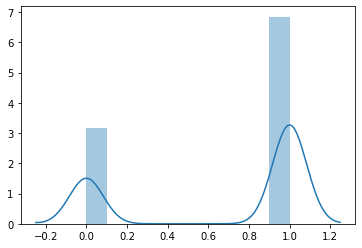

In [79]:
import seaborn as sns
sns.distplot(binarise_mat(test_mat[test_mat!=0]))

In [86]:
assert val_mat[val_mat!=0].shape==test_mat[test_mat!=0].shape

In [127]:
val_bool=val_mat!=0
test_bool=test_mat!=0
assert train_mat[val_bool].sum()==0
assert train_mat[test_bool].sum()==0 
assert test_mat[val_bool].sum()==0
val_entries=val_mat[val_bool]
test_entries=test_mat[test_bool]

In [128]:
#Creating the one-hot encoded item category matrix 
business_id_included=tr_df.groupby("business_id").count().index
assert business_df.business_id.isin(business_id_included).sum()==len(business_id_included)
business_bool=business_df.business_id.isin(business_id_included)
business_cat=[]
business_included_df=business_df[business_bool]
for i in range(business_included_df.shape[0]):
    business_cat.append(business_included_df.categories.iloc[i].split(','))
business_cat_nested=business_cat.copy()
business_cat=functools.reduce(operator.iconcat,business_cat, [])
business_list=list(set(business_cat))
item_bow=np.zeros((len(business_cat_nested),len(business_list)))
for i in range(len(business_cat_nested)):
    item_bow[i]=np.array(pd.Series(business_list).isin(pd.Series(business_cat_nested[i])))*1

In [132]:
np.save("item_bow.npy",item_bow)

In [89]:
sp.save_npz("full_coo.npz",full_coo)

In [90]:
sp.save_npz("val_bool_easy.npz",sp.coo_matrix(val_bool))
sp.save_npz("test_bool_easy.npz",sp.coo_matrix(test_bool))
sp.save_npz("val_entries_explicit_easy.npz",sp.coo_matrix(val_entries))
sp.save_npz("test_entries_explicit_easy.npz",sp.coo_matrix(test_entries))

In [351]:
tr_mat[test_bool]=0
tr_mat[val_bool]=0

In [91]:
sp.save_npz("tr_explicit_nosampling_easy.npz",sp.coo_matrix(train_mat))

In [290]:
def binarise_mat(mat):
        bin_mat=np.zeros_like(mat)
        bin_mat[mat>=4]=1
        bin_mat[mat<4]=0
        assert bin_mat[mat>=4].all()==1
        assert bin_mat[mat<4].all()==0
        return bin_mat

In [92]:
tr_bin=binarise_mat(train_mat)
val_entries_bin=binarise_mat(val_entries)
test_entries_bin=binarise_mat(test_entries)

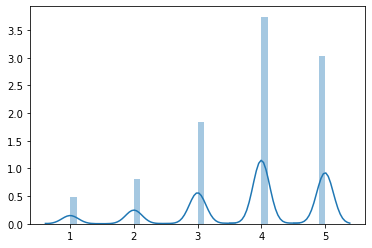

In [134]:
sns.distplot(train_mat[train_mat!=0])

In [93]:
sp.save_npz("tr_implicit_nosampling_easy.npz",sp.coo_matrix(tr_bin))

In [94]:
sp.save_npz("val_entries_implicit_easy.npz",sp.coo_matrix(val_entries_bin))
sp.save_npz("test_entries_implicit_easy.npz",sp.coo_matrix(test_entries_bin))
sp.save_npz("known_mask_nosampling_easy.npz",sp.coo_matrix(train_mat!=0))

In [95]:
train_data=sp.load_npz("tr_implicit_nosampling_easy.npz").todense()
known_mask=sp.load_npz("known_mask_nosampling_easy.npz").todense()
val_entries=sp.load_npz("val_entries_implicit_easy.npz").todense()
test_entries=sp.load_npz("test_entries_implicit_easy.npz").todense()
test_bool=sp.load_npz("test_bool_easy.npz").todense()
val_bool=sp.load_npz("val_bool_easy.npz").todense()

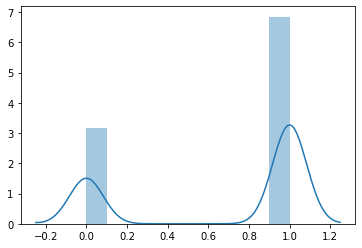

In [96]:
sns.distplot(test_entries)

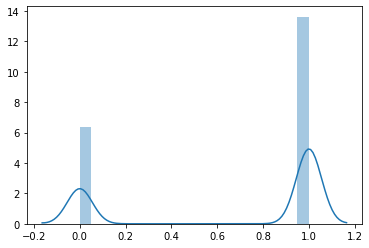

In [97]:
sns.distplot(train_data[known_mask])

#### For the harder generalisation task

In [98]:
full_coo=sp.load_npz("full_coo.npz")
full_df=full_coo.todense()

In [99]:
full_df.shape

(5336, 5524)

In [100]:
no_users=full_coo.shape[0]

In [101]:
u_idx=list(range(no_users))

In [102]:
train_percent=0.8
val_percent=0.1
no_train=int(no_users*train_percent)
no_val=int(no_users*val_percent)

In [103]:
np.random.shuffle(u_idx)

In [104]:
tr_df_hard=full_df[u_idx][:no_train]
val_df_hard=full_df[u_idx][no_train:no_train+no_val]
test_df_hard=full_df[u_idx][no_train+no_val:]

In [107]:
tr_df_hard.shape

(4268, 5524)

In [108]:
known_mask_hard=tr_df_hard!=0
val_bool_hard=val_df_hard!=0
test_bool_hard=test_df_hard!=0

In [23]:
def create_set(mat,full_known_bool,fold_in=True):
    
    mat_to_return=np.array(mat.copy())
    entries=mat_to_return[full_known_bool]
    a=entries.copy()
    no_entries=len(a)
    sampled_idx=random.sample(list(range(no_entries)),k=int(no_entries*0.8))
    fold_in_bool=np.isin(list(range(no_entries)),sampled_idx)
    assert (fold_in_bool).sum()==int(no_entries*0.8)

   
    if fold_in==True:
        a[~fold_in_bool]=0
        percent=0.8
       
        assert a.shape==entries.shape
    else:
        percent=0.2
        a[fold_in_bool]=0
     
        
    mat_to_return[full_known_bool]=a
   
    return mat_to_return
    

In [109]:
val_fold_in=create_set(val_df_hard,val_bool_hard,fold_in=True)
val_report=create_set(val_df_hard,val_bool_hard,fold_in=False)

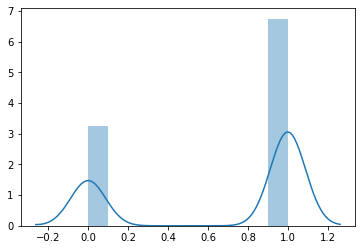

In [110]:
sns.distplot(binarise_mat(test_fold_in[test_fold_in!=0]))

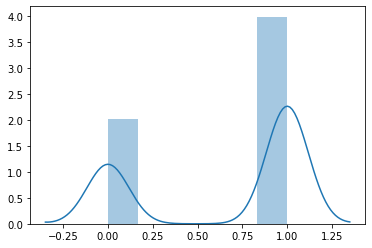

In [111]:
sns.distplot(binarise_mat(test_report[test_report!=0]))

In [112]:
test_fold_in=create_set(test_df_hard,test_bool_hard,fold_in=True)
test_report=create_set(test_df_hard,test_bool_hard,fold_in=False)

In [113]:
sp.save_npz("val_fold_in_implicit.npz",sp.coo_matrix(binarise_mat(val_fold_in)))
sp.save_npz("test_fold_in_implicit.npz",sp.coo_matrix(binarise_mat(test_fold_in)))
sp.save_npz("val_report_implicit.npz",sp.coo_matrix(binarise_mat(val_report)))
sp.save_npz("test_report_implicit.npz",sp.coo_matrix(binarise_mat(test_report)))
sp.save_npz("val_fold_in_bool.npz",sp.coo_matrix(val_fold_in!=0))
sp.save_npz("val_report_bool.npz",sp.coo_matrix(val_report!=0))
sp.save_npz("test_fold_in_bool.npz",sp.coo_matrix(test_fold_in!=0))
sp.save_npz("test_report_bool.npz",sp.coo_matrix(test_report!=0))
sp.save_npz("test_report_bool.npz",sp.coo_matrix(test_report!=0))

In [114]:
sp.save_npz("tr_explicit_nosampling_hard.npz",sp.coo_matrix(tr_df_hard))
sp.save_npz("tr_implicit_nosampling_hard.npz",sp.coo_matrix(binarise_mat(tr_df_hard)))
sp.save_npz("known_mask_nosampling_hard.npz",sp.coo_matrix(known_mask_hard))

In [117]:
sp.load_npz("tr_implicit_nosampling_hard.npz").todense().shape

(4268, 5524)

### Sampling unreported ratings for the training set

In [4]:
def mat_to_array(mat,axis):
    return np.array(np.squeeze(mat,axis=axis))[0]

In [139]:
def sampling_unreported(tr_mat,val_bool,test_bool,hard_gen):
    #Counting the number of rating per user
    rating_count_user=np.sum(tr_mat!=0,axis=1)
    #Counting the number of rating per item
    rating_count_item=np.sum(tr_mat!=0,axis=0)
    #Computing mean activity level across users 
    mean_count_user=round(rating_count_user.mean(),0)
    #Computing mean rating for each user
    users_mean=np.sum(tr_mat,axis=1)/rating_count_user
    users_mean=mat_to_array(users_mean,axis=1)
    
    #Computing mean rating for each item
    item_mean=np.sum(tr_mat,axis=0)/rating_count_item
    item_mean[np.isnan(item_mean)]=0
    item_mean=mat_to_array(item_mean,axis=0)
    
    item_idx=np.array(range(tr_mat.shape[1]))
    user_idx=np.array(range(tr_mat.shape[0]))
    tr_mat_sampled=tr_mat.copy()
    
    #Selecting users with below average activity level 
    user_idx_to_sample=user_idx[mat_to_array(rating_count_user<mean_count_user,axis=1)]
    #Computing the number of item sampled for the selected users 
    r_count_user=np.sum(tr_mat_sampled[user_idx_to_sample]!=0,axis=1)
    no_sampled=mat_to_array(mean_count_user-r_count_user,axis=1)
    
    for i in range(len(user_idx_to_sample)):
    
        #generating a boolean array that select the missing entries for user u
        u=user_idx_to_sample[i]
        #selecting items that do not have any rating in the training set
        miss_bool=mat_to_array(tr_mat_sampled[u]==0,axis=0)
        miss_idx=item_idx[miss_bool]

        if hard_gen==True:
            #selecting the index of the items that do not have any rating in the training set
            idx_to_exclude=item_idx[mat_to_array(rating_count_item==0,axis=0)]
        else:
            assert val_bool.shape==tr_mat.shape
            assert test_bool.shape==tr_mat.shape
            idx_to_exclude=item_idx[mat_to_array(np.logical_or(np.logical_or((val_bool[u]),(test_bool[u]),(rating_count_item==0)),(rating_count_item==0)),axis=0)]
        #computing the indices of the pool of candidate sample while excluding the items that do not have any rating in the training set
        miss_idx=miss_idx[np.isin(miss_idx,idx_to_exclude,invert=True)]
        sampled_miss_idx=random.sample(range(len(miss_idx)),int(no_sampled[i]))
        sampled_item_idx=miss_idx[sampled_miss_idx]
        mean_sampled_item=item_mean[sampled_item_idx]
        mean_sampled_user=users_mean[i]
        if no_sampled[i]>=4:
            alpha=0.8
        else:
            alpha=0.6
        sampled_r=alpha*mean_sampled_item+(1-alpha)*mean_sampled_user
        if np.sum(tr_mat_sampled[u,sampled_item_idx]!=0)!=0:
            print("error1! at"+str(i))
            break
        tr_mat_sampled[u,sampled_item_idx]=sampled_r
        if np.sum(tr_mat_sampled[u]!=0,axis=1)<6:
            print("error2! at"+str(i))
            break
        #Checking if the sampling worked as intended
    assert np.sum(tr_mat_sampled!=0,axis=1).min()==mean_count_user
    assert tr_mat_sampled[val_bool].sum()==0
    assert tr_mat_sampled[test_bool].sum()==0
    return tr_mat_sampled



In [140]:
tr_mat=sp.load_npz("tr_explicit_nosampling_easy.npz").todense()
val_bool=sp.load_npz("val_bool_easy.npz").todense()
test_bool=sp.load_npz("test_bool_easy.npz").todense()
hard_gen=False
tr_sampled_easy=sampling_unreported(tr_mat,val_bool,test_bool,hard_gen)

C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [141]:
scipy.sparse.save_npz("tr_explicit_sampled_easy.npz",sp.coo_matrix(tr_sampled_easy))
scipy.sparse.save_npz("tr_implicit_sampled_easy.npz",sp.coo_matrix(binarise_mat(tr_sampled_easy)))
scipy.sparse.save_npz("known_mask_sampled_easy.npz",sp.coo_matrix(tr_sampled_easy!=0))

In [118]:
tr_mat=sp.load_npz("tr_explicit_nosampling_hard.npz").todense()


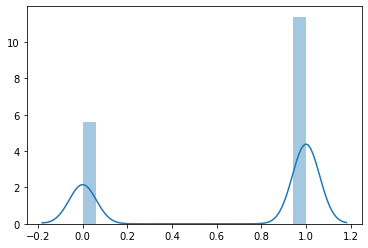

In [8]:
sns.distplot(binarise_mat(tr_mat)[tr_mat!=0])

In [120]:
tr_mat=sp.load_npz("tr_explicit_nosampling_hard.npz").todense()
val_bool=False
test_bool=False
hard_gen=True
tr_sampled_hard=sampling_unreported(tr_mat,val_bool,test_bool,hard_gen)

C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


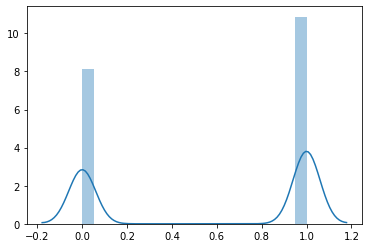

In [10]:
sns.distplot(binarise_mat(tr_sampled_hard)[tr_sampled_hard!=0])

In [122]:
scipy.sparse.save_npz("known_mask_sampled_hard.npz",sp.coo_matrix(tr_sampled_hard!=0))
scipy.sparse.save_npz("tr_explicit_sampled_hard.npz",sp.coo_matrix(tr_sampled_hard))
scipy.sparse.save_npz("tr_implicit_sampled_hard.npz",sp.coo_matrix(binarise_mat(tr_sampled_hard)))

In [123]:
train=sp.load_npz("tr_implicit_sampled_hard.npz").todense()
mask=sp.load_npz("known_mask_sampled_hard.npz").todense()

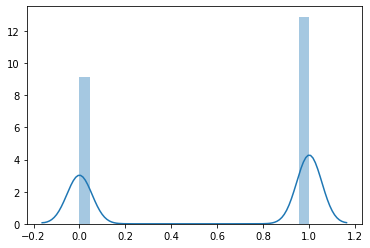

In [124]:
sns.distplot(train[mask])

 ### Binarising the explicit ratings

In [181]:
val_bool=sp.load_npz("val_bool_hard.npz").todense()
test_bool=sp.load_npz("test_bool_hard.npz").todense()
val_mat_hard=sp.load_npz("val_df_hard.npz").todense()
test_mat_hard=sp.load_npz("test_df_hard.npz").todense()
#val_entries=np.load("val_entries.npy")
#test_entries=np.load("test_entries.npy")
tr_sampled_coo=sp.load_npz("tr_sampled_hard_coo.npz")

In [172]:
tr_csr=tr_sampled_coo.tocsr()
known_mask_csr=tr_csr!=0
sp.save_npz("known_mask_hard_csr.npz",known_mask_csr)

In [173]:
val_hard_bin=np.zeros_like(val_mat_hard)

In [201]:
tr_csr[tr_csr.todense()!=0]

matrix([[5., 4., 5., ..., 4., 5., 4.]])

In [177]:
val_hard_bin[val_bool_hard]

matrix([[0., 1., 1., ..., 0., 1., 0.]])

In [6]:
def binarise_mat(mat):
        bin_mat=np.zeros_like(mat)
        bin_mat[mat>=4]=1
        bin_mat[mat<4]=0
        assert bin_mat[mat>=4].all()==1
        assert bin_mat[mat<4].all()==0
        return bin_mat

In [191]:
val_bin_hard=binarise_mat(val_mat_hard)
test_bin_hard=binarise_mat(test_mat_hard)

In [194]:
sp.save_npz("val_hard_bin.npz",sp.coo_matrix(val_bin_hard))
sp.save_npz("test_hard_bin.npz",sp.coo_matrix(test_bin_hard))

In [128]:
def binarise(array,axis=0):
    return np.matrixlib.matrix(list(map(lambda x:1 if x>=4 else 0 ,array)))

In [129]:
known_r_tr=mat_to_array(tr_csr[known_mask_csr],axis=0)
r_tr_bin=binarise(known_r_tr)
tr_csr[known_mask_csr]=r_tr_bin
np.sum(tr_csr>1)

0

In [130]:
tr_coo_bin=tr_csr.tocoo()

In [131]:
sp.save_npz("tr_sampled_coo_hard_bin.npz",tr_coo_bin)

In [340]:
full_csr=full_coo.tocsr()

In [341]:
val_bool_csr=sp.csr_matrix(val_bool)
test_bool_csr=sp.csr_matrix(test_bool)
val_entries_csr=sp.csr_matrix(val_entries)
test_entries_csr=sp.csr_matrix(test_entries)

In [342]:
np.sum(full_csr[val_bool_csr]!=val_entries_csr)

0

In [343]:
val_entries_bin=binarise(np.squeeze(val_entries,0))

In [344]:
test_entries_bin=binarise(np.squeeze(test_entries,0))

In [345]:
np.save("val_entries_bin.npy",val_entries_bin)
np.save("test_entries_bin.npy",test_entries_bin)

In [346]:
sp.save_npz("val_bool_csr.npz",val_bool_csr)
sp.save_npz("test_bool_csr.npz",test_bool_csr)